<a href="https://colab.research.google.com/github/carenpg/Proyecto2-Analitica/blob/main/RegresionLogistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

data = pd.read_csv("/content/drive/MyDrive/Analitica/Telco-Customer-Churn-V2.csv")

print(data.head())

   gender SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female            No     Yes         No     1.0           No   
1    Male            No      No         No    34.0          Yes   
2    Male            No      No         No     2.0          Yes   
3    Male            No      No         No    45.0           No   
4  Female            No      No         No     2.0          Yes   

        MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  'No phone service'             DSL             No          Yes   
1                  No             DSL            Yes           No   
2                  No             DSL            Yes          Yes   
3  'No phone service'             DSL            Yes           No   
4                  No   'Fiber optic'             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes        

In [113]:
print(data.columns)

print(f"Número de columnas: {data.shape[1]}")

print(f"Número de cuentas: {data.shape[0]}")

data.info

print(data.dtypes)


data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')


#Calculamos el porcentaje que equivalen los datos faltantes
missing_percentage = data.isnull().mean() * 100
# Eliminamos las columnas que tengan más del 30 porciento de datos faltantes
columns_to_drop = missing_percentage[missing_percentage > 30].index.tolist()
data = data.drop(columns=columns_to_drop)

print(data.isnull().sum())

missing_percent = ((data.isnull().sum() / len(data)) * 100)
print(missing_percent)

data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)

cols_fill_no = ['OnlineSecurity', 'OnlineBackup', 'TechSupport']
for col in cols_fill_no:
    data[col].fillna('No', inplace=True)

data['MonthlyCharges'].fillna(data['MonthlyCharges'].median(), inplace=True)

# Verificar que no haya nulos restantes
print(data.isnull().sum())

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
Número de columnas: 20
Número de cuentas: 7043
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
gender      

<ipython-input-113-a048372155e2>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)
<ipython-input-113-a048372155e2>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value,

In [114]:
data = pd.get_dummies(data, columns=["gender", "Partner", "Dependents", "PhoneService",
                                 "MultipleLines", "InternetService", "OnlineSecurity",
                                 "OnlineBackup", "DeviceProtection", "TechSupport",
                                 "StreamingTV", "StreamingMovies", "PaperlessBilling"], drop_first=True)


In [115]:
# Verificar si hay columnas de tipo objeto (string)
columnas_categoricas = data.select_dtypes(include=["object"]).columns
print("Columnas categóricas no convertidas:", columnas_categoricas)

# Aplicar One-Hot Encoding si aún hay variables categóricas sin transformar
data = pd.get_dummies(data, columns=columnas_categoricas, drop_first=True)

# Confirmar que ya no haya datos de tipo string
print(data.dtypes)



Columnas categóricas no convertidas: Index(['SeniorCitizen', 'Contract', 'PaymentMethod', 'Churn'], dtype='object')
tenure                                     float64
MonthlyCharges                             float64
TotalCharges                               float64
gender_Male                                   bool
Partner_Yes                                   bool
Dependents_Yes                                bool
PhoneService_Yes                              bool
MultipleLines_No                              bool
MultipleLines_Yes                             bool
InternetService_DSL                           bool
InternetService_No                            bool
OnlineSecurity_No                             bool
OnlineSecurity_Yes                            bool
OnlineBackup_No                               bool
OnlineBackup_Yes                              bool
DeviceProtection_No                           bool
DeviceProtection_Yes                          bool
TechSupport_No   

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
# Separar variables predictoras y variable objetivo
X = data.drop(columns=["Churn_Yes"])
y = data["Churn_Yes"]

# Dividir en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Manejo de valores faltantes
imputer = SimpleImputer(strategy="mean")  # Imputa los valores faltantes con la media de cada columna
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Guardar los nombres de las características después de la transformación
feature_names = X.columns[:X_train.shape[1]]

# Estandarizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Entrenar el modelo de Regresión Logística
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

# Hacer predicciones
y_pred = modelo.predict(X_test)

# Evaluación del modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))



Accuracy: 0.8190205819730305
Reporte de Clasificación:
               precision    recall  f1-score   support

       False       0.86      0.90      0.88      1036
        True       0.69      0.58      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.76      1409
weighted avg       0.81      0.82      0.81      1409



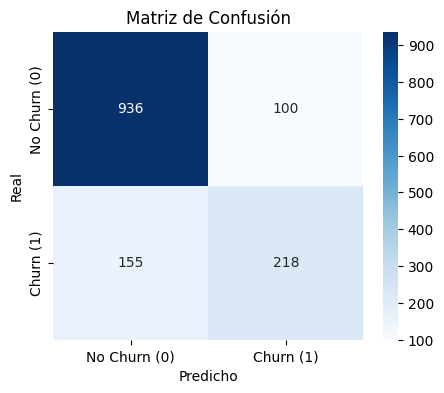

In [122]:
# Matriz de confusión con etiquetas personalizadas
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn (0)', 'Churn (1)'], yticklabels=['No Churn (0)', 'Churn (1)'])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

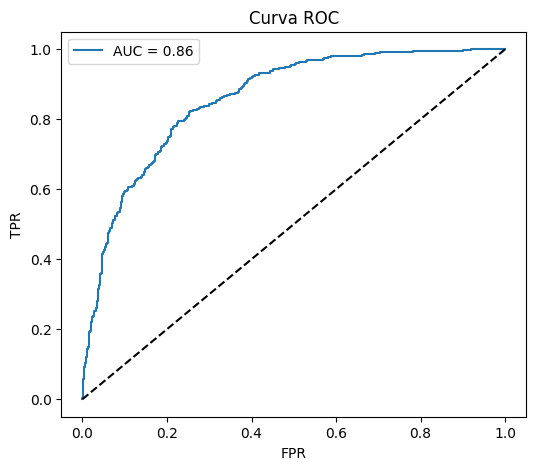

In [118]:
# AUC-ROC
y_probs = modelo.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend()
plt.show()


In [119]:

# Importancia de características
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': modelo.coef_[0]
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print("Características más importantes en la predicción de churn:")
print(feature_importance)

Características más importantes en la predicción de churn:
                                    Feature  Importance
26                  Contract_Month-to-month    0.346962
22                      StreamingMovies_Yes    0.264326
20                          StreamingTV_Yes    0.240108
11                        OnlineSecurity_No    0.235275
2                              TotalCharges    0.220894
15                      DeviceProtection_No    0.188523
16                     DeviceProtection_Yes    0.176177
28         PaymentMethod_'Electronic check'    0.161186
23                     PaperlessBilling_Yes    0.160616
19                           StreamingTV_No    0.123189
21                       StreamingMovies_No    0.098855
24                        SeniorCitizen_Yes    0.053388
8                         MultipleLines_Yes    0.037769
12                       OnlineSecurity_Yes    0.021912
4                               Partner_Yes    0.018789
29             PaymentMethod_'Mailed check'  